In [19]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

In [20]:
y1950 = pd.read_csv('1950.xls')
y1960 = pd.read_csv('1960.xls')
y1970 = pd.read_csv('1970.xls')
y1980 = pd.read_csv('1980.xls')
y1990 = pd.read_csv('1990.xls')
y2000 = pd.read_csv('2000.xls')
y2010 = pd.read_csv('2010.xls')
all_data = pd.concat([y1950,y1960,y1970,y1980,y1990,y2000,y2010])

In [21]:
from sklearn.model_selection import train_test_split
X = all_data.drop('pop', axis=1)
y = all_data['pop']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [22]:
#Creating a dataframe with all the predictors
X = train[['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur','acous', 'spch']]
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train[['bpm', 'nrgy', 'dnce', 'dB', 'live', 'val', 'dur','acous', 'spch']]

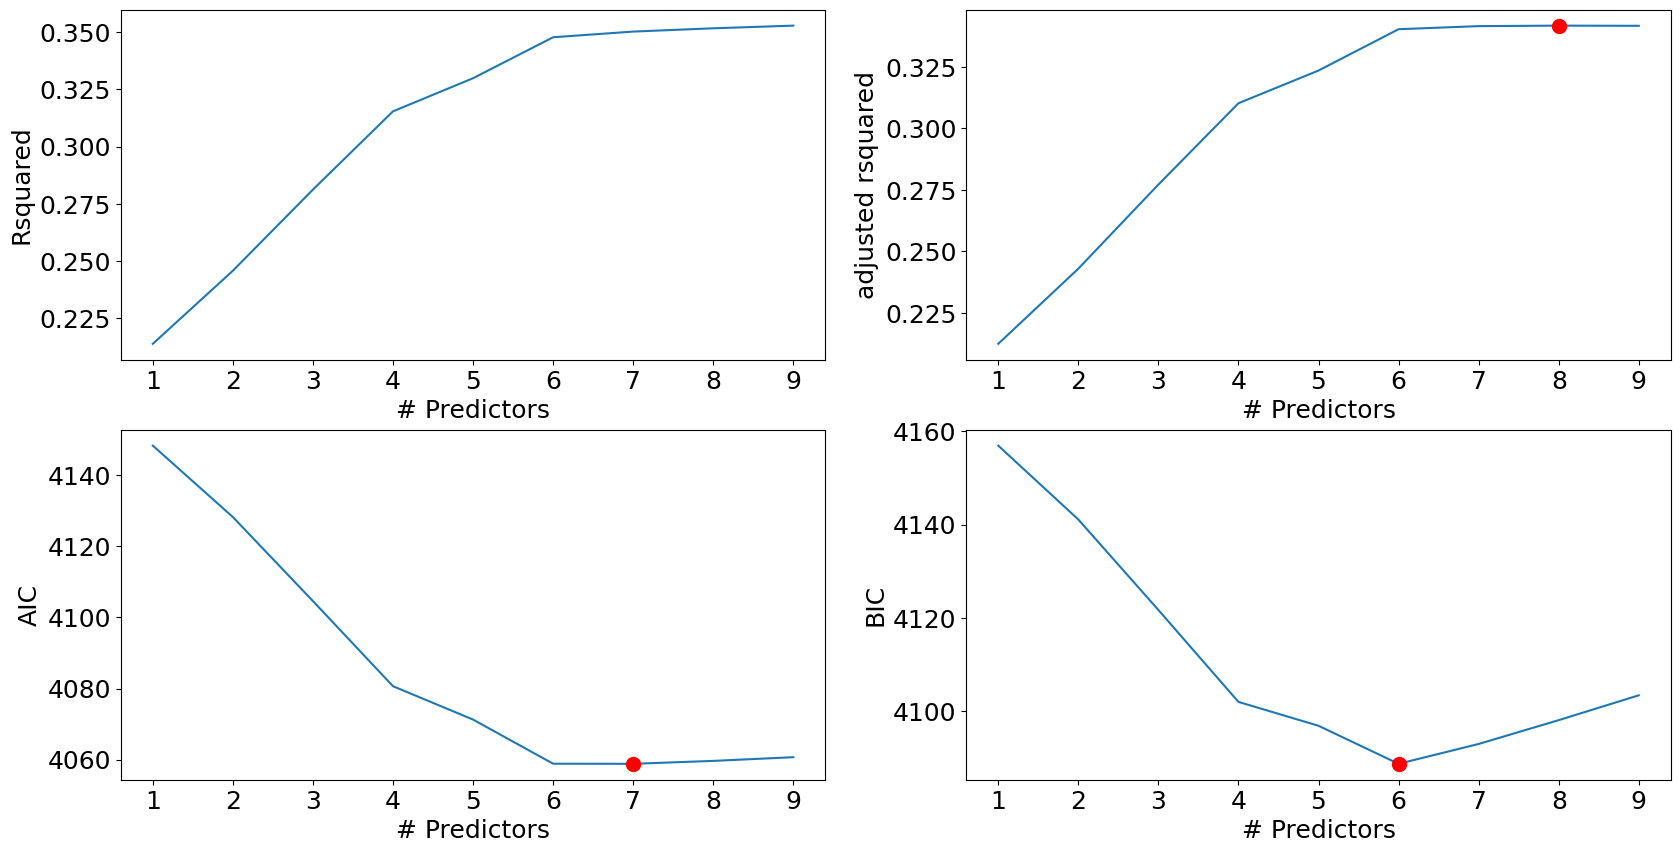

In [23]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('pop~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [18]:
#Including 2-factor interactions of predictors in train and 'X'. Note that we need train to develop the model, and X to 
#find 'k' variable subsets from amongst all the predictors under consideration
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 

C:\Users\tyrot\AppData\Local\Temp\ipykernel_19064\979990102.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
C:\Users\tyrot\AppData\Local\Temp\ipykernel_19064\979990102.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
C:\Users\tyrot\AppData\Local\Temp\ipykernel_19064\979990102.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")
#IT CRASHED oops use stepwise

Processed 45 models on 1 predictors in 0.16713762283325195 seconds.
Processed 990 models on 2 predictors in 4.307538032531738 seconds.
Processed 14190 models on 3 predictors in 76.091392993927 seconds.


In [24]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [25]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [26]:
models_best = forward_selection()

Processed  9 models on 1 predictors in 0.027617216110229492 seconds.
Processed  8 models on 2 predictors in 0.04074525833129883 seconds.
Processed  7 models on 3 predictors in 0.027278900146484375 seconds.
Processed  6 models on 4 predictors in 0.02771925926208496 seconds.
Processed  5 models on 5 predictors in 0.026012182235717773 seconds.
Processed  4 models on 6 predictors in 0.022473573684692383 seconds.
Processed  3 models on 7 predictors in 0.022520065307617188 seconds.
Processed  2 models on 8 predictors in 0.013919353485107422 seconds.
Processed  1 models on 9 predictors in 0.007000923156738281 seconds.
Total elapsed time: 0.22679805755615234 seconds.


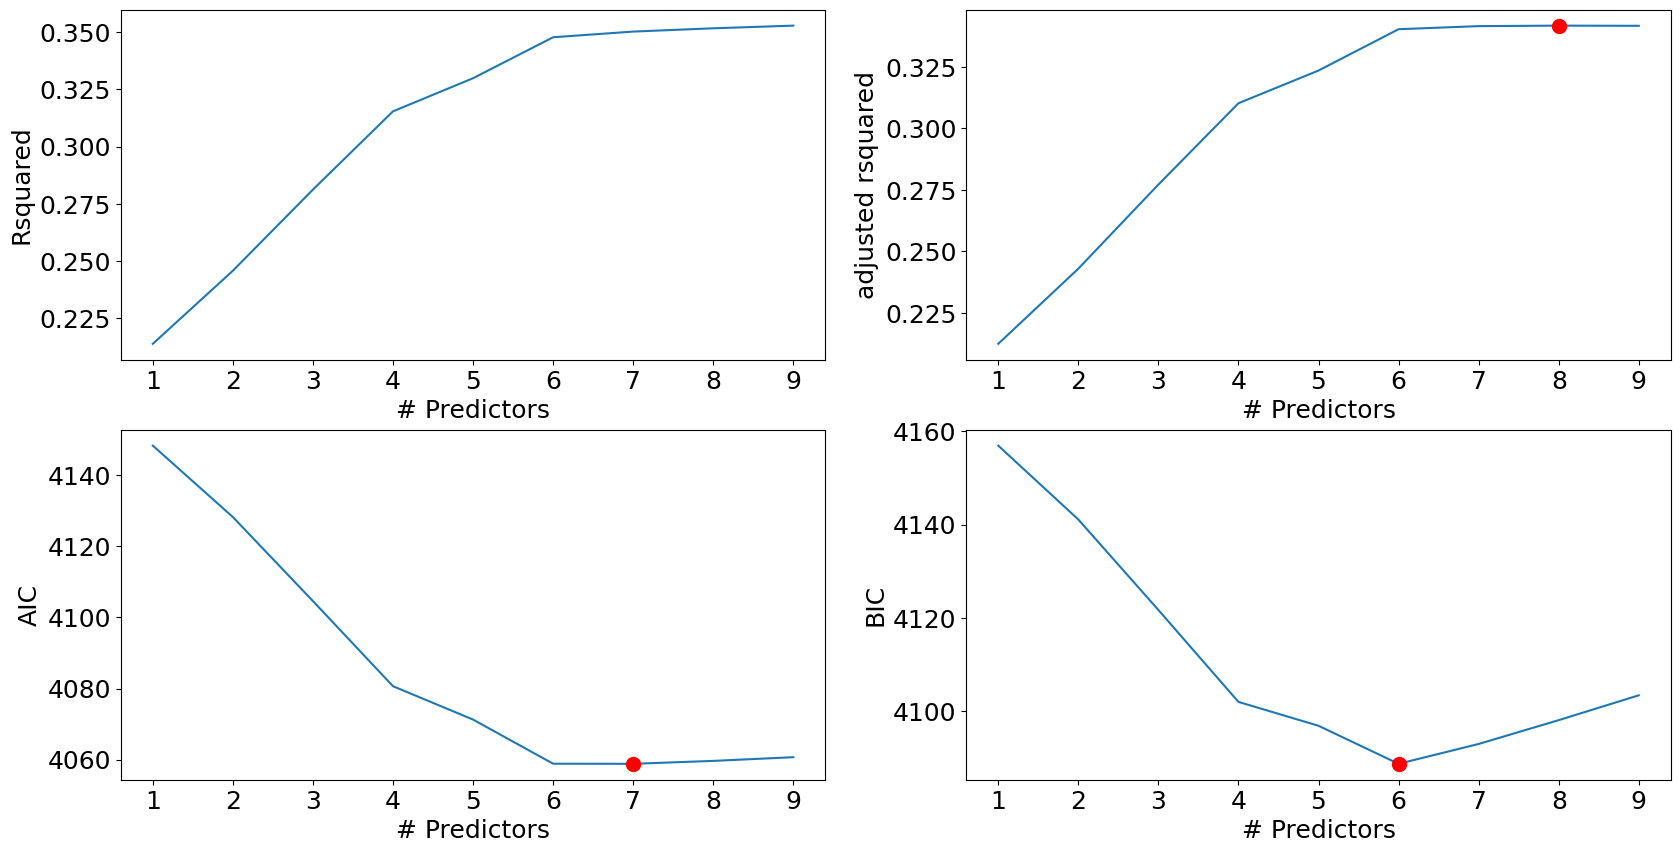

In [27]:
best_sub_plots()

In [28]:
best_fwd_reg_model = models_best['model'][6]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pop   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     46.75
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           6.53e-46
Time:                        20:56:02   Log-Likelihood:                -2022.4
No. Observations:                 533   AIC:                             4059.
Df Residuals:                     526   BIC:                             4089.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.5827      4.697     15.026      0.000      61.355      79.811
acous         -0.1697      0.024     -7.090      0.000      -0.217      -0.123
dur            0.0389      0.008      4.674      0.000       0.023       0.055
dB             1.0767      0.194      5.543      0.000       0.695       1.458
nrgy          -0.1181      0.041     -2.873      0.004      -0.199      -0.037
dnce           0.1801      0.038      4.742      0.000       0.105       0.255
val           -0.0961      0.025     -3.799      0.000      -0.146      -0.046
==============================================================================
Omnibus:                       11.190   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.409
Skew:                          -0.357   Prob(JB):                      0.00333
Kurtosis:                       3.068   Cond. No.                     2.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
#backward
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [30]:
models_best = backward_selection()

Processed  9 models on 8 predictors in 0.06444311141967773 seconds.
Processed  8 models on 7 predictors in 0.04708719253540039 seconds.
Processed  7 models on 6 predictors in 0.039170265197753906 seconds.
Processed  6 models on 5 predictors in 0.030539274215698242 seconds.
Processed  5 models on 4 predictors in 0.026560068130493164 seconds.
Processed  4 models on 3 predictors in 0.014079809188842773 seconds.
Processed  3 models on 2 predictors in 0.008695125579833984 seconds.
Processed  2 models on 1 predictors in 0.004503726959228516 seconds.
Total elapsed time: 0.25270676612854004 seconds.


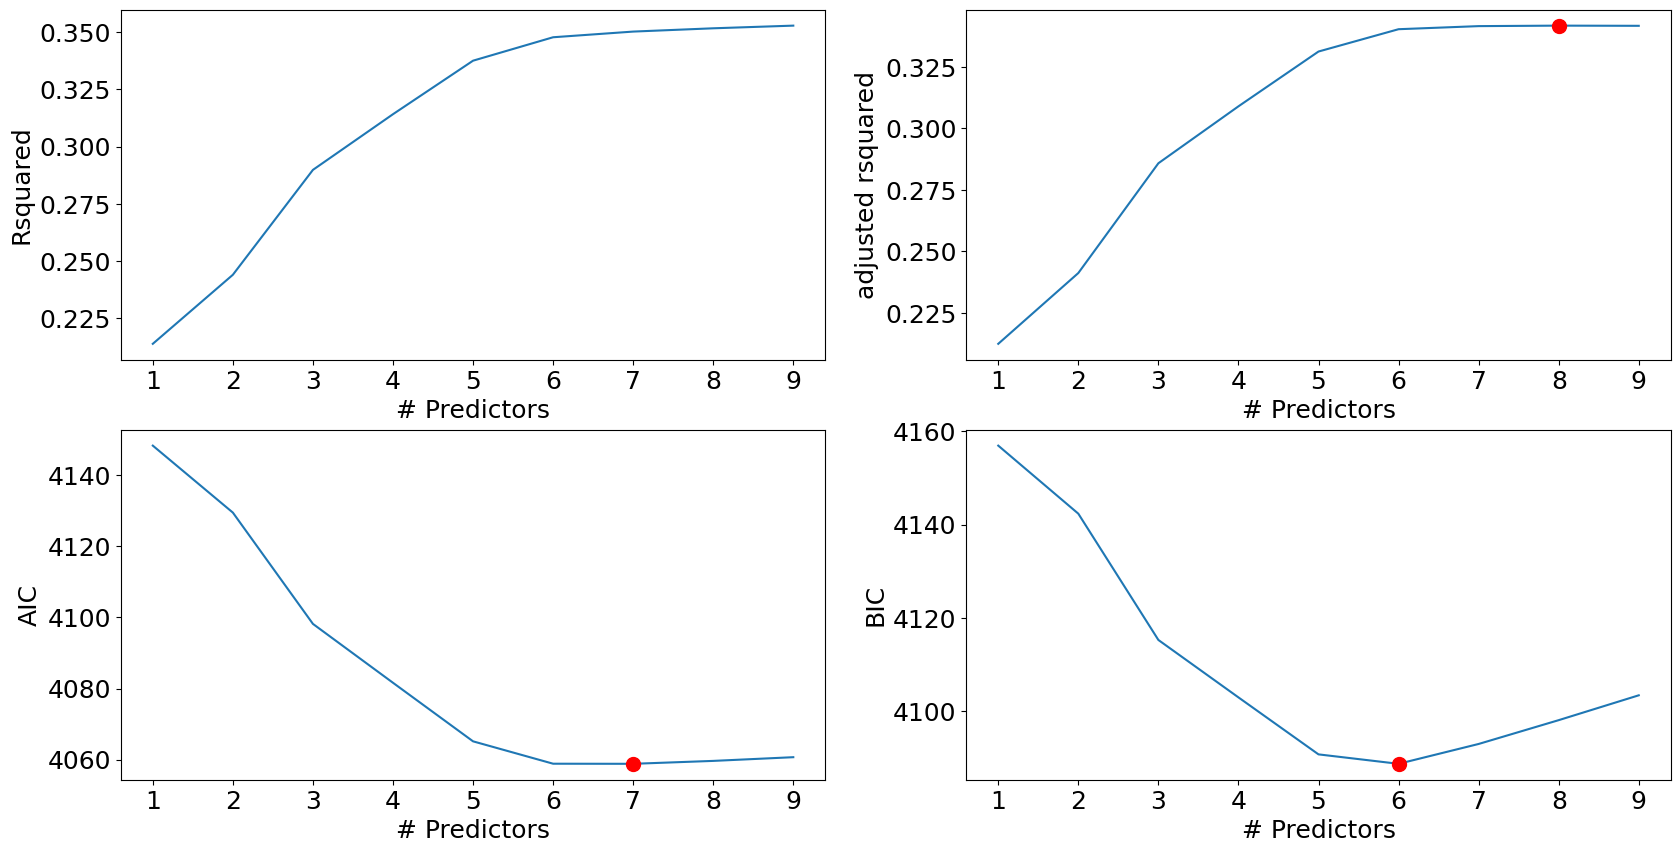

In [31]:
best_sub_plots()

In [32]:
best_bwd_reg_model = models_best['model'][6]
best_bwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pop   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     46.75
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           6.53e-46
Time:                        21:00:53   Log-Likelihood:                -2022.4
No. Observations:                 533   AIC:                             4059.
Df Residuals:                     526   BIC:                             4089.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.5827      4.697     15.026      0.000      61.355      79.811
nrgy          -0.1181      0.041     -2.873      0.004      -0.199      -0.037
dnce           0.1801      0.038      4.742      0.000       0.105       0.255
dB             1.0767      0.194      5.543      0.000       0.695       1.458
val           -0.0961      0.025     -3.799      0.000      -0.146      -0.046
dur            0.0389      0.008      4.674      0.000       0.023       0.055
acous         -0.1697      0.024     -7.090      0.000      -0.217      -0.123
==============================================================================
Omnibus:                       11.190   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.409
Skew:                          -0.357   Prob(JB):                      0.00333
Kurtosis:                       3.068   Cond. No.                     2.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
#Finding the RMSE of the model selected using the backward selection procedure, where the predictors
#include 2-factor interactions
pred_price = np.exp(best_bwd_reg_model.predict(test))
from sklearn.metrics import mean_squared_error
from math import sqrt

train_rmse = sqrt(mean_squared_error(train['pop'], best_bwd_reg_model.predict(train)))
test_rmse = sqrt(mean_squared_error(test['pop'], best_bwd_reg_model.predict(test)))

print('train rmse: ', train_rmse)
print('test rmse: ', test_rmse)

train rmse:  10.756107832841504
test rmse:  13.009560351987444


In [36]:
train_rmse = sqrt(mean_squared_error(train['pop'], best_fwd_reg_model.predict(train)))
test_rmse = sqrt(mean_squared_error(test['pop'], best_fwd_reg_model.predict(test)))

print('train rmse: ', train_rmse)
print('test rmse: ', test_rmse)

train rmse:  10.756107832841504
test rmse:  13.00956035198744
